# COVID-19 Analysis and Prediction: A Modified SEIR infectious Model

By Baiyan Ren, Zhaoyang Zhang

COVID-19 is a silent spreader. Most cases only exhibit mild to no symptoms, increasing the difficulty to control its spreading. Here, we modified the SEIR model by considering this characteristic as well as the "lockdown" rules. We studied three countries: US, Italy, and France. Compared with the real world data, this model fits the infection ratio and recover ratio very well.

I am keep working on this notebook and learning from the community. If you have any comments or questions, I'm happy to hear and answer.


# Import packages

In [ ]:
# Algebra
import numpy as np

# Dataframe
import pandas as pd

# Missing Analysis
import missingno as msno

# Modelling
from scipy import integrate
from scipy import optimize

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Map
import folium

# Datetime
from datetime import datetime


# Import datasets

Date source:
2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE ([GitHub link](https://github.com/CSSEGISandData/COVID-19))

In [ ]:
# Global dataset
global_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
global_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
global_recover_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
# US dataset
us_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
us_state_loc_csv = 'https://gist.githubusercontent.com/mbostock/9535021/raw/eaed7e5632735a6609f02d0ba0e55c031e14200d/us-state-capitals.csv'

In [ ]:
Confirmed = pd.read_csv(global_confirm_csv)
Death = pd.read_csv(global_death_csv)
Recover = pd.read_csv(global_recover_csv)
Confirmed_us_state = pd.read_csv(us_confirm_csv)
Death_us_state = pd.read_csv(us_death_csv)
us_state_loc = pd.read_csv(us_state_loc_csv)

# Data cleaning

Settings to show the full dataset when print()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

remove unnecessary columns

In [ ]:
# National dataset
Confirmed.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Death.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Recover.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])

US

national dataset

In [ ]:
# national dataset
us_confirmed = Confirmed[Confirmed['Country/Region'] == 'US']
us_confirmed = us_confirmed.T.reset_index()
us_confirmed = us_confirmed.iloc[1:]
us_confirmed.columns = ['date', 'positive']

us_death = Death[Death['Country/Region'] == 'US']
us_death = us_death.T.reset_index()
us_death = us_death.iloc[1:]
us_death.columns = ['date', 'death']

us_recover = Recover[Recover['Country/Region'] == 'US']
us_recover = us_recover.T.reset_index()
us_recover = us_recover.iloc[1:]
us_recover.columns = ['date', 'recovered']

us_statu = us_confirmed.join(us_death.set_index('date'), on='date')
us_status = us_statu.join(us_recover.set_index('date'), on='date')
us_status.reset_index(inplace=True, drop=True)

state-wise dataset

In [ ]:
# map
us_state_loc.drop(axis=1, inplace=True, columns=['description'])
us_state_loc = us_state_loc.rename(columns={'name': 'State'})

In [ ]:
# state-wise death cases dataset
Death_us_state.drop(axis=1, inplace=True, columns=['Lat', 'Long_', 'UID', 'iso2','iso3', 'code3', 'FIPS', 'Country_Region', 'Combined_Key'])
Death_us_state = Death_us_state.groupby('Province_State').sum()
Death_us_state.reset_index(inplace=True)
Death_us_state = Death_us_state.rename(columns={"Province_State": 'State'})
us_state_death = Death_us_state.join(us_state_loc.set_index('State'), on='State')
us_state_death = us_state_death.dropna()
state_pop = us_state_death.loc[:, ['State','Population']]

# state-wise confirmed cases dataset
Confirmed_us_state.drop(axis=1, inplace=True, columns=['Lat', 'Long_', 'UID', 'iso2','iso3', 'code3', 'FIPS', 'Country_Region', 'Combined_Key'])
Confirmed_us_state = Confirmed_us_state.groupby('Province_State').sum()
Confirmed_us_state.reset_index(inplace=True)
Confirmed_us_state = Confirmed_us_state.rename(columns={"Province_State": 'State'})
Confirmed_state_loc = Confirmed_us_state.join(us_state_loc.set_index('State'), on='State')
Confirmed_state_loc_pop = Confirmed_state_loc.join(state_pop.set_index('State'), on= 'State')
Confirmed_state_loc_pop = Confirmed_state_loc_pop.dropna()
cols = Confirmed_state_loc_pop.columns.tolist()
cols.insert(1, cols.pop(cols.index('Population')))
Confirmed_state_loc_pop = Confirmed_state_loc_pop.reindex(columns=cols)

In [ ]:
'''
today = '7/5/20'
Total_confirm = Confirmed_us_state.loc[:,['State', today]]
Total_confirm = Total_confirm.rename(columns={today: 'Confirmed case'})
Total_death = Death_us_state.loc[:,['State',today, 'Population']]
Total_death = Total_death.rename(columns={today:'Death case'})
Total_status = Total_confirm.join(Total_death.set_index('State'), on = 'State')
Total_status = Total_status.drop([2,9,13])
Total_status_t = Total_status.transpose()
Total_status_t.reset_index(inplace=True)
state_header = Total_status_t.iloc[0]
Total_status_t = Total_status_t.iloc[1:]
Total_status_t.columns = state_header
Total_status_t.set_index('State', inplace=True)
'''

In [ ]:
today='7/5/20'
Top_states = Confirmed_us_state.sort_values([today], ascending=False)
Top_states.reset_index(inplace=True, drop=True)
Top_states = Top_states.loc[0:9,['State', today]]
print(Top_states)

In [ ]:
Confirmed_us_state_t = Confirmed_us_state.transpose()
Confirmed_us_state_t.reset_index(inplace=True)
header = Confirmed_us_state_t.iloc[0]
Confirmed_us_state_t = Confirmed_us_state_t[1:]
Confirmed_us_state_t.columns = header
Confirmed_us_state_t = Confirmed_us_state_t.rename(columns={'State' : 'Date'})

In [ ]:
yaxis = np.linspace(0,500000, num=11, endpoint=True)
yaxis = yaxis.astype(int)
x = np.linspace(1,180,num=10,endpoint=False)
x = x.astype(int)
xaxis = Confirmed_us_state_t.iloc[x,0]

In [ ]:
sns.set()
plt.figure(figsize = (20,12))
for state in Top_states['State']:
    plt.plot(Confirmed_us_state_t['Date'], Confirmed_us_state_t[state])
plt.legend(header[1:], loc=0)
plt.yticks(yaxis, yaxis)
plt.xticks(xaxis, xaxis)
plt.show()

Map

In [ ]:
us_map_confirm = folium.Map(
         location=[37.0902, -95.7129],
         zoom_start = 4,
         tiles='CartoDB dark_matter')

    
for i in range(0,len(Confirmed_state_loc_pop)):
    r = (int(Confirmed_state_loc_pop.iloc[i, -3])/((int(Confirmed_state_loc_pop.iloc[i, 1])/1000)))*5
    lat = float(Confirmed_state_loc_pop.iloc[i, -2])
    long = float(Confirmed_state_loc_pop.iloc[i, -1])
    folium.vector_layers.CircleMarker(
            name = 'Confirmed case',
            radius = r,
            location = [lat, long],
            tooltip=str(Confirmed_state_loc_pop.iloc[i, 0]) + ' confirmed: ' + str(Confirmed_state_loc_pop.iloc[i, -3]),
            color = 'cadetblue',
            weight = .5,
            fill = True,
            alpha = 0.3,
            ).add_to(us_map_confirm)

In [ ]:
us_map_confirm

In [ ]:
us_map_death = folium.Map(
         location=[37.0902, -95.7129],
         zoom_start = 4,
         tiles='CartoDB dark_matter')

for i in range(0,len(us_state_death)):
    r = (int(us_state_death.iloc[i, -3])/(int(us_state_death.iloc[i, 1]/1000)))*50
    lat = float(us_state_death.iloc[i, -2])
    long = float(us_state_death.iloc[i, -1])
    folium.vector_layers.CircleMarker(
            name = 'Death case', 
            radius = r,
            location = [lat, long],
            tooltip=str(us_state_death.iloc[i, 0]) + 'death: ' + str(us_state_death.iloc[i, -3]),
            color = 'crimson',
            weight = .5,
            fill = True,
            alpha = 0.3,
            ).add_to(us_map_death)

In [ ]:
us_map_death

Italy

In [ ]:
itl_confirmed = Confirmed[Confirmed['Country/Region'] == 'Italy']
itl_confirmed = itl_confirmed.T.reset_index()
itl_confirmed = itl_confirmed.iloc[1:]
itl_confirmed.columns = ['date', 'positive']

itl_death = Death[Death['Country/Region'] == 'Italy']
itl_death = itl_death.T.reset_index()
itl_death = itl_death.iloc[1:]
itl_death.columns = ['date', 'death']

itl_recover = Recover[Recover['Country/Region'] == 'Italy']
itl_recover = itl_recover.T.reset_index()
itl_recover = itl_recover.iloc[1:]
itl_recover.columns = ['date', 'recovered']

itl_statu = itl_confirmed.join(itl_death.set_index('date'), on='date')
itl_status = itl_statu.join(itl_recover.set_index('date'), on='date')
itl_status.reset_index(inplace=True, drop=True)

France

In [ ]:
frc_confirmed = Confirmed[Confirmed['Country/Region'] == 'France']
frc_confirmed = frc_confirmed.sum(axis=0)
frc_confirmed = frc_confirmed.T.reset_index()
frc_confirmed = frc_confirmed.iloc[1:]
frc_confirmed.columns = ['date', 'positive']

frc_death = Death[Death['Country/Region'] == 'France']
frc_death = frc_death.sum(axis=0)
frc_death = frc_death.T.reset_index()
frc_death = frc_death.iloc[1:]
frc_death.columns = ['date', 'death']

frc_recover = Recover[Recover['Country/Region'] == 'France']
frc_recover = frc_recover.sum(axis=0)
frc_recover = frc_recover.T.reset_index()
frc_recover = frc_recover.iloc[1:]
frc_recover.columns = ['date', 'recovered']

frc_statu = frc_confirmed.join(frc_death.set_index('date'), on='date')
frc_status = frc_statu.join(frc_recover.set_index('date'), on='date')
frc_status.reset_index(inplace=True, drop=True)

# The modified SEIR Model


Inspired by Kaike Wesley Reis's work in Kaggle community, I generated a modified SEIR model for COVID-19 spread.

In a closed population without births or deaths, the SEIR model is:

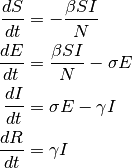

In the case of COVID-19, the viral carriers ("exposed population) do not exhibit symptoms, yet are infectious. So, the SEIR model is modified as below:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\frac{\beta&space;S(I&plus;E)}{N}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\frac{\beta&space;S(I&plus;E)}{N}" title="\frac{\mathrm{d}S }{\mathrm{d} t}= -\frac{\beta S(I+E)}{N}" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;S(I&plus;E)}{N}-\sigma&space;E" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;S(I&plus;E)}{N}-\sigma&space;E" title="\frac{\mathrm{d}E }{\mathrm{d} t}=\frac{\beta S(I+E)}{N}-\sigma E" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" title="\frac{\mathrm{d}I }{\mathrm{d} t}=\sigma E-\gamma I" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I" title="\frac{\mathrm{d}R }{\mathrm{d} t}= \gamma I" /></a>

We included the "exposed population" in the first and second formula, because it participates in the viral transmission.

Accordingly, we modified the functions:

In [ ]:
# FUNCTION 
def seir_model_ode(y, t, params): 
    '''
    Arguments:
    - y: dependent variables
    - t: independent variable (time)
    - params: Model parameters
    '''
    # Parameters to find
    infection_rate = params[0]
    recovery_rate = params[1]
    exposed_rate = params[2]
    
    # Y variables
    s = y[0]
    e = y[1]
    i = y[2]
    r = y[3]
    
    # SIR EDO System 
    dsdt = -exposed_rate*s*(i+e) 
    dedt = (exposed_rate*s*(i+e)) - (infection_rate*e)
    didt = (infection_rate*e) - (recovery_rate*i)
    drdt = recovery_rate*i
    
    # Return our system
    return (dsdt, dedt, didt, drdt)

In [ ]:
# FUNCTION - Calculate SEIR Model in t (time as days) based on given parameters
def calculate_seir_model(params, t, initial_condition):
    # Create an alias to our seir ode model to pass params to try
    seir_ode = lambda y,t:seir_model_ode(y, t, params)
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=seir_ode, y0=initial_condition, t=t)
    
    # Return results
    return ode_result

In [ ]:
# FUNCTION - Auxiliar function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
    
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = i_r_true[0] - fit_result[:,2]
    residual_r = i_r_true[1] - fit_result[:,3]

    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))
    
    # Return results
    return residual

In [ ]:
def countryLockdown(N, status,lockdownDay,countryName):
    
    """inputs:
    N: population in the country
    status: dataframe of the country
    lockdownDay: number of days since begining of data to the date of lockdown
    """
    
    # Define Initial Condition (necessary for ODE solve)
    I_start = status.loc[0, 'positive']/N
    E_start = (status.loc[14, 'positive'] - status.loc[0, 'positive'])/N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered']/N

    ## Set this values as a tuple
    ic = (S_start, E_start, I_start, R_start)
    # Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
    beforelockdown=status.loc[0:lockdownDay]
    afterlockdown=status.loc[lockdownDay+1:]
    i_r_true_bf = (list(beforelockdown['positive']/N), list(beforelockdown['recovered']/N))
    i_r_true_af = (list(afterlockdown['positive']/N), list(afterlockdown['recovered']/N))
    # Define a time array measure in days
    time_opt_bf = range(0, lockdownDay+1)
    time_opt_af = range(0, len(afterlockdown))
    time_opt =range(0,len(status))
    # define initial condition after lockdown
    I_start_af = status.loc[len(beforelockdown), 'positive']/N
    E_start_day=min(len(status['date']),len(beforelockdown)+14)
    E_start_af = (status.loc[E_start_day, 'positive'] - status.loc[len(beforelockdown), 'positive'])/N
    S_start_af = 1 - E_start_af - I_start_af
    R_start_af = status.loc[len(beforelockdown), 'recovered']/N
    ## Set this values as a tuple
    ic_af = (S_start_af, E_start_af, I_start_af, R_start_af)
    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01]
    optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_bf, ic, i_r_true_bf),
                                          ftol=1.49012e-15)
    optimal_params_af, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_af, ic_af, i_r_true_af),
                                          ftol=1.49012e-15)
    print('## '+countryName+' before lockdown')
    print('Optimize infection rate: ', optimal_params[0])
    print('Optimize recovered rate: ', optimal_params[1])
    print('Optimize exposed rate: ', optimal_params[2])
    print('## '+countryName+' after lockdown')
    print('Optimize infection rate: ', optimal_params_af[0])
    print('Optimize recovered rate: ', optimal_params_af[1])
    print('Optimize exposed rate: ', optimal_params_af[2])
    
    # Fit test
    ## Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    ir_af = optimal_params_af[0]
    rr_af = optimal_params_af[1]
    er_af = optimal_params_af[2]
    ## Calculate a curve based on those parameters
    fit_result_bf = calculate_seir_model((ir, rr, er), time_opt_bf, ic)
    fit_result_af = calculate_seir_model((ir_af, rr_af, er_af), time_opt_af, ic_af)
    ## Define plot object
    plt.figure(figsize=[6,4])
    ## Plot real and predicted infection
    plt.plot(time_opt, i_r_true_bf[0]+i_r_true_af[0], 'ro', markersize = 1)
    plt.plot(time_opt, np.hstack((fit_result_bf[:,2],fit_result_af[:,2])), 'c')
    plt.legend(['Real infection', 'Predicted infection'],loc=2, fontsize=8)
    plt.title('Infected cases - '+countryName,fontsize=20)
    plt.xlabel('Days since Jan-22-2020', fontsize=12)
    plt.ylabel('Proportion of population', fontsize=12)
    
    
    ## Plot real and predicted recover
    plt.figure(figsize=[6,4])
    plt.plot(time_opt, i_r_true_bf[1]+i_r_true_af[1], 'ro', markersize = 1)
    plt.plot(time_opt, np.hstack((fit_result_bf[:,3],fit_result_af[:,3])), 'g')
    plt.legend(['Real recover', 'Predicted recover'],loc=2, fontsize=8)
    plt.title('Recovered cases - '+countryName,fontsize=20);
    plt.xlabel('Days since Jan-22-2020', fontsize=12)
    plt.ylabel('Proportion of population', fontsize=12)
    
    # Prediction
    ## Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start="2020-02-01",end="2021-01-01", freq='D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir_af, rr_af, er_af), pred_range, ic_af)
    pred_death = (pred_result[:,1]+pred_result[:,2])*0.05 # based on 5% death rate
    time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304, 335]]
    time_labels = ['Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
    ## Plot SEIR
    plt.figure(figsize=[6,4])
    plt.plot(pred_time, pred_result[:,0],color='blue') #susceptible
    plt.plot(pred_time, pred_result[:,1],color='red') #exposed
    plt.plot(pred_time, pred_result[:,2],color='cyan') #infected
    plt.plot(pred_time, pred_result[:,3],color='green') #recovered
    plt.plot(pred_time, pred_death,color='black')
    plt.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected','Recovered','Death'], fontsize=8)
    plt.title('SEIR predictions', fontsize=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Proportion of population', fontsize=12)
    plt.xticks(time_axis, time_labels, rotation='vertical');

In [ ]:
def countryNolockdown(N, status,countryName):
    # Define Initial Condition (necessary for ODE solve)
    I_start = status.loc[0, 'positive']/N
    E_start = (status.loc[14, 'positive'] - status.loc[0, 'positive'])/N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered']/N
    ## Set this values as a tuple
    ic = (S_start, E_start, I_start, R_start)
    i_r_true = (list(status['positive']/N), list(status['recovered']/N))
    time_opt =range(0,len(status))
    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01]
    optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt, ic, i_r_true),
                                          ftol=1.49012e-15)
    print('## '+countryName)
    print('Optimize infection rate: ', optimal_params[0])
    print('Optimize recovered rate: ', optimal_params[1])
    print('Optimize exposed rate: ', optimal_params[2])
    # Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    fit_result = calculate_seir_model((ir, rr, er), time_opt, ic)
    
    # Plot the results for Infected/Recovered
    ## Define plot object
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

    ## Plot process
    axes[0].plot(time_opt, i_r_true[0], 'ro')
    axes[0].plot(time_opt, fit_result[:,2], 'p')
    axes[0].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
    axes[0].set_title('Infected cases - '+countryName,fontsize=20)
    axes[1].plot(time_opt, i_r_true[1], 'ro')
    axes[1].plot(time_opt, fit_result[:,3], 'r')
    axes[1].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
    axes[1].set_title('Recovered cases - '+countryName,fontsize=20);
    plt.show()
    
    # Prediction
    # Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start="2020-04-01",end="2020-12-31", freq='D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir, rr, er), pred_range, ic)
    pred_icu = (pred_result[:,1]+pred_result[:,2])*0.08 #predict icu requirement based on 5% death rate
    time_axis = [pred_time[i] for i in[0, 30, 61, 91, 122, 153, 183, 214, 244, 274]]
    ## Plot SEIR
    plt.figure(figsize=[20,10])
    plt.plot(pred_time, pred_result[:,0], color = 'blue') 
    plt.plot(pred_time, pred_result[:,1], color = 'red')
    plt.plot(pred_time, pred_result[:,2], color = 'purple')
    plt.plot(pred_time, pred_result[:,3], color = 'green')
    plt.plot(pred_time, pred_icu,color='black')
    plt.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected','Recovered','ICU'], fontsize=10)
    plt.title('SEIR predictions', fontsize=20)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Total cases', fontsize=15)
    plt.xticks(time_axis)
    #plt.hlines(y=icu/N, xmin=pred_time[0], xmax=pred_time[274], color = 'yellow', linestyles = 'dashed');

# Case study
# United States

In [ ]:
countryLockdown(328*1e6,us_status,58,'US')

# Italy

In [ ]:
countryLockdown(60.36*1e6, itl_status,47,'Italy')

# France

In [ ]:
countryLockdown(66.99*1e6,frc_status,55,'France')


This model fits very well with the current data in US, Italy and France. According to its prediction, the proportion of infected people will reach the peak in around September, under the condition of lockdown. 
Generally, the percentage of death is around 5% (depending on the local hospital capacity and the number of screening tests). Thus, we hypothesized that 5% of infected population requires ICU care. Then we could predict that the amount of ICU requirement will increase until September, which is the predicted peak of infection.
